In [2]:
!pip install -q git+https://github.com/forrestbao/pyeeg.git

## Python Packages

In [3]:
import os
import time
import math
import keras
import timeit
import warnings
import csv

import numpy as np
import pyeeg as pe
import pickle as pickle
import pandas as pd
import keras.backend as K
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, normalize
from tensorflow.keras.callbacks import Callback
from keras.models import Sequential, Model
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.layers import (
    Dense, Conv1D, MaxPooling1D, 
    Conv2D, MaxPooling2D, Dropout,
    Flatten, Convolution1D, ZeroPadding1D,
    BatchNormalization, Activation,
)

In [4]:
warnings.filterwarnings('ignore')

In [5]:
keras.utils.set_random_seed(0)

In [6]:
!mkdir /kaggle/working/data/
!mkdir /kaggle/working/data/data_training
!mkdir /kaggle/working/data/label_training
!mkdir /kaggle/working/data/data_testing
!mkdir /kaggle/working/data/label_testing

## Signal Parameters

In [7]:
channel = [1,2,3,4,6,11,13,17,19,20,21,25,29,31] #14 Channels chosen
band = [4,8,12,16,25,45] #5 bands (Delta/Theta/Alpha/Beta/Gamma)
window_size = 256 #Averaging band power of 2 sec
step_size = 16 #Each 0.125 sec update once
sample_rate = 128 #Sampling rate of 128 Hz
subjectList = ['01','02','03', '04', '05', '06'] #List of subjects

## Signal Processing

In [8]:
def FFT_Processing (sub, channel, band, window_size, step_size, sample_rate): # Fast Fourier Transform = FFT
    '''
    arguments:  string subject
                list channel indice
                list band
                int window size for FFT
                int step size for FFT
                int sample rate for FFT
    return:     void
    '''
    meta = []
    with open("/kaggle/input/deap-dataset/data_preprocessed_python/s" + sub + '.dat', 'rb') as file:

        subject = pickle.load(file, encoding='latin1') #resolve the python 2 data problem by encoding : latin1

        for i in range (0,40):
            # loop over 0-39 trails
            data = subject["data"][i]
            labels = subject["labels"][i]
            start = 0;

            while start + window_size < data.shape[1]:
                meta_array = []
                meta_data = [] #meta vector for analysis
                for j in channel:
                    X = data[j][start : start + window_size] #Slice raw data over 2 sec, at interval of 0.125 sec
                    Y = pe.bin_power(X, band, sample_rate) #FFT over 2 sec of channel j, in seq of theta, alpha, low beta, high beta, gamma
                    meta_data = meta_data + list(Y[0])

                meta_array.append(np.array(meta_data))
                meta_array.append(labels)

                meta.append(np.array(meta_array, dtype=object))    
                start = start + step_size
                
        meta = np.array(meta)
        np.save('/kaggle/working/data/s' + sub, meta, allow_pickle=True, fix_imports=True)

In [9]:
for subjects in subjectList:
    FFT_Processing (subjects, channel, band, window_size, step_size, sample_rate)

In [10]:
data_training = []
label_training = []
data_testing = []
label_testing = []

for subjects in subjectList:
    with open('/kaggle/working/data/s' + subjects + '.npy', 'rb') as file:
        sub = np.load(file,allow_pickle=True)
        for i in range (0,sub.shape[0]):
            if i % 4 == 0:
                data_testing.append(sub[i][0])
                label_testing.append(sub[i][1])
            else:
                data_training.append(sub[i][0])
                label_training.append(sub[i][1])

In [11]:
np.save('/kaggle/working/data/data_training', np.array(data_training), allow_pickle=True, fix_imports=True)
np.save('/kaggle/working/data/label_training', np.array(label_training), allow_pickle=True, fix_imports=True)
print("training dataset:", np.array(data_training).shape, np.array(label_training).shape)

np.save('/kaggle/working/data/data_testing', np.array(data_testing), allow_pickle=True, fix_imports=True)
np.save('/kaggle/working/data/label_testing', np.array(label_testing), allow_pickle=True, fix_imports=True)
print("testing dataset:", np.array(data_testing).shape, np.array(label_testing).shape)

training dataset: (87840, 70) (87840, 4)
testing dataset: (29280, 70) (29280, 4)


In [12]:
with open('/kaggle/working/data/data_training.npy', 'rb') as fileTrain:
    X  = np.load(fileTrain)
    
with open('/kaggle/working/data/label_training.npy', 'rb') as fileTrainL:
    Y  = np.load(fileTrainL)
    
X = normalize(X)
Z = np.ravel(Y[:, [3]])

Arousal_Train = np.ravel(Y[:, [0]])
Valence_Train = np.ravel(Y[:, [1]])
Domain_Train = np.ravel(Y[:, [2]])
Like_Train = np.ravel(Y[:, [3]])

In [13]:
# Arousal and Valence
Z_arousal = np.ravel(Y[:, [0]])
Z_valence = np.ravel(Y[:, [1]])

Z_arousal_masked = (Z_arousal > 6.5).astype(int)
Z_valence_masked = (Z_valence > 6.5).astype(int)

In [14]:
y_train = np.array([Z_arousal_masked, Z_valence_masked]).T
y_train.shape

(87840, 2)

In [15]:
X.shape

(87840, 70)

In [16]:
x_train = np.array(X[:])

In [17]:
with open('/kaggle/working/data/data_testing.npy', 'rb') as fileTrain:
    M  = np.load(fileTrain)
    
with open('/kaggle/working/data/label_testing.npy', 'rb') as fileTrainL:
    N  = np.load(fileTrainL)

M = normalize(M)
L = np.ravel(N[:, [3]])

Arousal_Test = np.ravel(N[:, [0]])
Valence_Test = np.ravel(N[:, [1]])
Domain_Test = np.ravel(N[:, [2]])
Like_Test = np.ravel(N[:, [3]])

In [18]:
# Arousal and Valence
L_arousal = np.ravel(N[:, [0]])
L_valence = np.ravel(N[:, [1]])

L_arousal_masked = (L_arousal > 6.5).astype(int)
L_valence_masked = (L_valence > 6.5).astype(int)

In [19]:
y_test = np.array([L_arousal_masked, L_valence_masked]).T
y_test.shape

(29280, 2)

In [20]:
x_test = np.array(M[:])

## Feature Scaling

In [21]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [22]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1], 1)

In [23]:
x_train.shape

(87840, 70, 1)

In [24]:
batch_size = 256
num_classes = 2
epochs = 200
input_shape=(x_train.shape[1], 1)

In [25]:
input_shape

(70, 1)

## Model Logs

In [26]:
csv_file = "cnn_model_log.csv" # This file will be used to save the model's evolution

In [27]:
headers = ["epoch", "loss", "accuracy", "val_loss", "val_accuracy"]

In [28]:
with open(csv_file, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(headers)

In [29]:
class CSVLoggerCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Append metrics to the CSV file at the end of each epoch
        with open(csv_file, mode="a", newline="") as file:
            writer = csv.writer(file)
            writer.writerow([
                epoch + 1,  # Epoch index starts from 0, so add 1 for readability
                logs["loss"],
                logs["accuracy"],
                logs["val_loss"],
                logs["val_accuracy"]
            ])

## Model Training

In [30]:
model = Sequential([
    Conv1D(128, kernel_size=3, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Conv1D(128, kernel_size=3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Conv1D(64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='tanh'),
    Dropout(0.2),
    Dense(32, activation='tanh'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='sigmoid')
])

In [31]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 70, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 70, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 35, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 35, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 35, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 17, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 17, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,930 (433.32 KB)

 Trainable params: 110,418 (431.32 KB)

 Non-trainable params: 512 (2.00 KB)

In [32]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [33]:
m = model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=1, validation_data=(x_test, y_test), callbacks=[CSVLoggerCallback()])

Epoch 1/100


I0000 00:00:1734113076.507581    1932 service.cc:145] XLA service 0x7df4c0015b30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734113076.507648    1932 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  52/2745 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.6560 - loss: 0.6863 

I0000 00:00:1734113083.690207    1932 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2745/2745 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.7186 - loss: 0.5925 - val_accuracy: 0.7227 - val_loss: 0.5596
Epoch 2/100
2745/2745 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.7656 - loss: 0.5656 - val_accuracy: 0.8211 - val_loss: 0.5420
Epoch 3/100
2745/2745 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7911 - loss: 0.5460 - val_accuracy: 0.8400 - val_loss: 0.5182
Epoch 4/100
2745/2745 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8029 - loss: 0.5285 - val_accuracy: 0.8682 - val_loss: 0.5007
Epoch 5/100
2745/2745 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8074 - loss: 0.5116 - val_accuracy: 0.8428 - val_loss: 0.4877
Epoch 6/100
2745/2745 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8029 - loss: 0.4964 - val_accuracy: 0.8364 - val_loss: 0.4629
Epoch 7/100
2745/2745 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8131 - loss: 0.4820 - val_accuracy: 0.8681 - val_loss: 0.4524
Epoch 8/100
2745/2745 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8193 - loss: 0.4686 - va

In [34]:
model.save('/kaggle/working/cnn-model.h5')

## Model Evaluation

In [35]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

915/915 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8642 - loss: 0.2689
Test loss: 0.2688101828098297
Test accuracy: 0.8911885023117065


## Performance Visualization

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


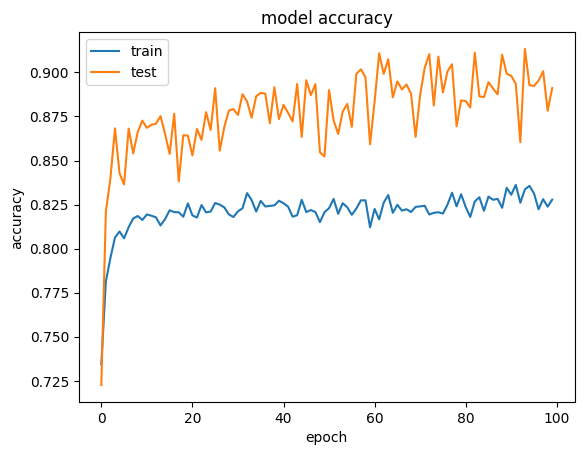

In [36]:
print(m.history.keys())
# Summarize history for accuracy
plt.plot(m.history['accuracy'])
plt.plot(m.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

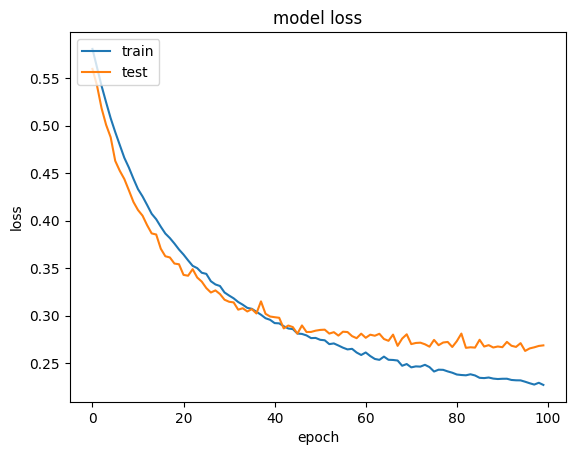

In [37]:
# Summarize history for loss
plt.plot(m.history['loss'])
plt.plot(m.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

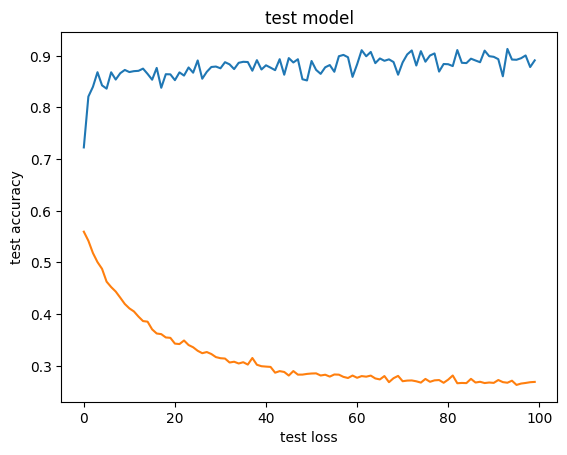

In [38]:
plt.plot(m.history['val_accuracy'])
plt.plot(m.history['val_loss'])
plt.title('test model')
plt.ylabel('test accuracy')
plt.xlabel('test loss')
plt.show()